In [ ]:
from evoVAE.utils.datasets import MSA_Dataset
import evoVAE.utils.seq_tools as st
import evoVAE.utils.metrics as mt
from evoVAE.models.seqVAETest import SeqVAETest
from evoVAE.trainer.seqVAE_train import seq_train
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import numpy as np

pd.set_option("display.max_rows", None)

# Config

In [ ]:
config = {
        # Dataset info
        "dataset": "playground",
        "seq_theta": 0.2, # reweighting 
        "AA_count": 21, # standard AA + gap
        
        # ADAM 
        "learning_rate": 1e-5, # ADAM
        "weight_decay": 0.01, # ADAM

        # Hidden units 
        "momentum": 0.1, 
        "dropout": 0.5,

        # Training loop 
        "epochs": 100,
        "batch_size": 128,
        "max_norm": 1.0, # gradient clipping
        
        # Model info
        "architecture": "SeqVAETest",
        "latent_dims": 2,
        "hidden_dims": [32, 16],
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# Read in data

In [ ]:
from pathlib import Path
DATA_PATH = "/Users/sebs_mac/OneDrive - The University of Queensland/honours/data/gfp_alns/independent_runs/no_synthetic/ancestors/seqs/"
filepath = DATA_PATH + 'run_14_ancestors.fa'
aln = st.read_aln_file(filepath)
#aln


In [ ]:

train, val = train_test_split(aln, test_size=0.2)


# TRAINING
train_dataset = MSA_Dataset(
    train["encoding"], train.index, train["id"]
)

# VALIDATION
val_dataset = MSA_Dataset(
    val["encoding"], val.index, val["id"]
)

# DATA LOADERS #
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False)

print(len(train_loader), len(val_loader))
next(iter(train_loader))[0].shape

# Build model

In [ ]:
# get the sequence length 
SEQ_LEN = 0
BATCH_ZERO = 0
SEQ_ZERO = 0
seq_len = train_dataset[BATCH_ZERO][SEQ_ZERO].shape[SEQ_LEN]
input_dims = seq_len * config['AA_count']

seq_len, input_dims

# use preset structure for hidden dimensions 
model = SeqVAETest(input_dims=input_dims, latent_dims=config['latent_dims'], hidden_dims=config['hidden_dims'], config=config) 
model

In [ ]:
# very small nummy data 
dummy = next(iter(train_loader))[0].float()
print(dummy.shape)
# reconstruct input, note it has been flattened 
log_p, z_sample, z_mu, z_logvar = model(dummy)

# grab the shape of the input for reshaping
orig_shape = log_p.shape[0:-1]

# add on extra dim, then make it one-hot encoding shape (obs, seq_len, AA_count)
log_p = torch.unsqueeze(log_p, -1)
log_p = log_p.view(orig_shape + (-1, config['AA_count']))

In [ ]:
mut_data = pd.read_csv('../data/dms_data/GFP_AEQVI_Sarkisyan_2016.csv')
subset = mut_data.copy()[0:10]

In [ ]:
encoding, _ = st.encode_and_weight_seqs(mut_data['mutated_sequence'], 0.2, reweight=False)
mut_data['encoding'] = encoding
mut_data[0:10]

In [ ]:
mut_data.to_pickle("GFP_AEQVI_Sarkisyan_2016_dms_encoded.pkl")

In [ ]:
encoding, weights = st.encode_and_weight_seqs(subset['mutated_sequence'], 0.2, reweight=True)
subset['encoding'] = encoding
subset['weights'] = weights
subset

In [ ]:
metadata = pd.read_csv("../data/dms_data/DMS_substitutions.csv")
metadata = metadata[metadata["DMS_id"].str.contains("GFP")]
metadata


In [ ]:

import sklearn
import sklearn.preprocessing


wild_type = metadata['target_seq'].to_numpy()[0]
wild_one_hot = torch.Tensor(st.seq_to_one_hot(wild_type)).unsqueeze(0)

model.eval()
wild_model_encoding, _, _, _ = model(wild_one_hot)

orig_shape = wild_model_encoding.shape[0:-1]

wild_model_encoding = torch.unsqueeze(wild_model_encoding, -1)

wild_model_encoding = wild_model_encoding.view(orig_shape + (-1, model.AA_COUNT))


# get the wild type encoding 
wild_model_encoding = wild_model_encoding.squeeze(0)

one_hot = wild_one_hot.squeeze(0)
wt_prob = mt.seq_log_probability(one_hot, wild_model_encoding)

variant_encodings = torch.Tensor(np.stack(subset['encoding'].values))
variant_model_outputs, _, _, _ = model(variant_encodings)

model_scores =[]
for variant, var_one_hot in zip(variant_model_outputs, variant_encodings):
    
    print(variant.shape)
    var_model_encoding = torch.unsqueeze(variant, -1)
    print(var_model_encoding.shape)
    var_model_encoding = var_model_encoding.view(orig_shape + (-1, model.AA_COUNT))
    var_model_encoding = var_model_encoding.squeeze(0)
    log_prob = mt.seq_log_probability(var_one_hot, var_model_encoding)
    
    # make variant fitness relative to the wild type
    model_scores.append(log_prob - wt_prob)
    
model_scores = pd.Series(model_scores)
model_scores, subset['DMS_score']



In [ ]:
a = torch.Tensor([0,0,0])
b = torch.Tensor([1,2,3])
a - b

In [ ]:
spear_rho, k_recall, ndcg, roc_auc = mt.summary_stats(predictions=model_scores, actual=subset['DMS_score'], actual_binned=subset['DMS_score_bin'])
spear_rho, k_recall, ndcg, roc_auc

Reading the alignment: ../data/test.aln
Checking for bad characters: ['B', 'J', 'X', 'Z']
Performing one hot encoding
Number of seqs: 6


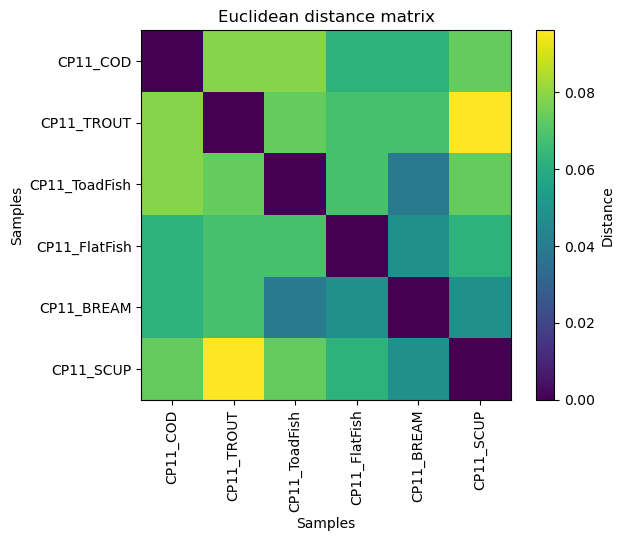

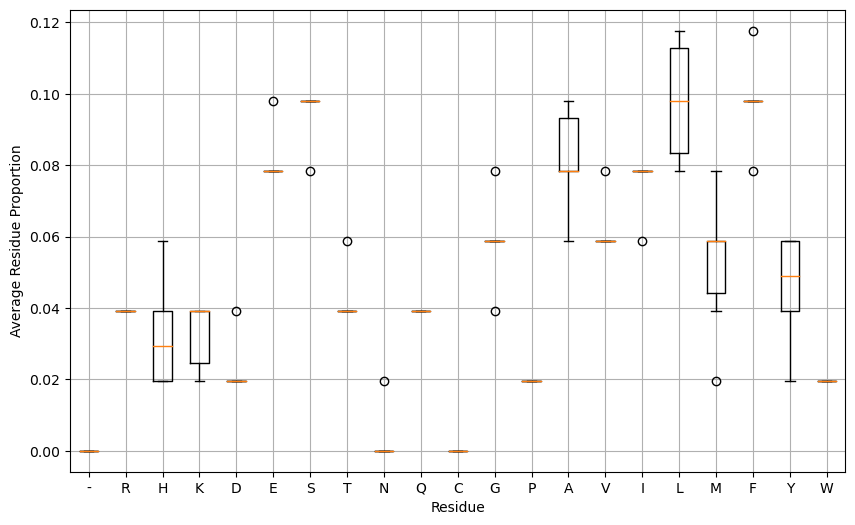

In [1]:
import evoVAE.utils.seq_tools as st
from evoVAE.utils.seq_tools import GAPPY_PROTEIN_ALPHABET, calc_position_prob_matrix, calc_mean_seq_embeddings, calc_average_residue_distribution, calc_position_prob_matrix, create_euclidean_dist_matrix, plot_residue_distributions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict

seqs = st.read_aln_file("../data/test.aln")
encode = calc_mean_seq_embeddings(seqs)
avgs = calc_average_residue_distribution(encode, GAPPY_PROTEIN_ALPHABET)
ppm = calc_position_prob_matrix(seqs)

create_euclidean_dist_matrix(encode, plot=True)


plot_residue_distributions(encode)
#print(ppm)
#print()
#print(avgs)


In [27]:
encode

{'CP11_COD': array([0.        , 0.03921569, 0.05882353, 0.03921569, 0.01960784,
        0.07843137, 0.09803922, 0.03921569, 0.        , 0.03921569,
        0.        , 0.05882353, 0.01960784, 0.07843137, 0.05882353,
        0.07843137, 0.07843137, 0.05882353, 0.11764706, 0.01960784,
        0.01960784]),
 'CP11_TROUT': array([0.        , 0.03921569, 0.03921569, 0.03921569, 0.03921569,
        0.07843137, 0.07843137, 0.03921569, 0.        , 0.03921569,
        0.        , 0.03921569, 0.01960784, 0.09803922, 0.07843137,
        0.07843137, 0.11764706, 0.01960784, 0.09803922, 0.03921569,
        0.01960784]),
 'CP11_ToadFish': array([0.        , 0.03921569, 0.01960784, 0.03921569, 0.01960784,
        0.07843137, 0.09803922, 0.03921569, 0.        , 0.03921569,
        0.        , 0.07843137, 0.01960784, 0.05882353, 0.05882353,
        0.07843137, 0.11764706, 0.03921569, 0.09803922, 0.05882353,
        0.01960784]),
 'CP11_FlatFish': array([0.        , 0.03921569, 0.03921569, 0.01960784, 0.

In [53]:
from scipy.spatial.distance import euclidean

def population_profile_deviation(population: pd.DataFrame, sample: pd.DataFrame) -> float:

    # get the average residue proportion across the population 
    pop_means = calc_mean_seq_embeddings(population)
    pop_means = calc_average_residue_distribution(pop_means)

    # put this in an array to allow comparisons
    pop_vector = np.array([x['mean'] for x in pop_means.values()])

    sample_means = calc_mean_seq_embeddings(sample)
    sample_n = len(sample_means)


    total_dist = 0.0
    for sample_vector in sample_means.values():
        total_dist += euclidean(pop_vector, sample_vector)

    mean_deviation = total_dist / sample_n
   
    return mean_deviation
    


Reading the alignment: ../data/test.aln
Checking for bad characters: ['B', 'J', 'X', 'Z']
Performing one hot encoding
Number of seqs: 6
Reading the alignment: ../data/test_1.aln
Checking for bad characters: ['B', 'J', 'X', 'Z']
Performing one hot encoding
Number of seqs: 1
Reading the alignment: ../data/test_2.aln
Checking for bad characters: ['B', 'J', 'X', 'Z']
Performing one hot encoding
Number of seqs: 2
Reading the alignment: ../data/test_3.aln
Checking for bad characters: ['B', 'J', 'X', 'Z']
Performing one hot encoding
Number of seqs: 3
Reading the alignment: ../data/test_4.aln
Checking for bad characters: ['B', 'J', 'X', 'Z']
Performing one hot encoding
Number of seqs: 4
Reading the alignment: ../data/test_5.aln
Checking for bad characters: ['B', 'J', 'X', 'Z']
Performing one hot encoding
Number of seqs: 5
0.04115461663434888
0.0
{'-': {'mean': 0.0, 'std': 0.0}, 'R': {'mean': 0.0392156862745098, 'std': 0.0}, 'H': {'mean': 0.0326797385620915, 'std': 0.014614823382351566}, 'K': {